# Optunaを用いてパラメータの最適化
## ベースラインモデルの作成

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold

import lightgbm as lgb

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from conf.config import DIRS, PARAMS, CFG
from utils import DataLoader, DataProcesser, DataEnginner, cross_val_train

### データの読み込み

In [2]:
# データのロード
dataloader = DataLoader()
train_df, test_df = dataloader.load_data()

# データの前処理
dataprocesser = DataProcesser(train_df, test_df)
trains, X_test = dataprocesser.preprocess()
X_train, y_train = trains["X_train"], trains["y_train"]

train dataの中に欠損値はありませんでした。
test dataの中に欠損値はありませんでした。
Train shape: (90615, 8)   test shape: (60411, 8)


,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
id,,,,,,,,
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975
...,...,...,...,...,...,...,...,...
90610,M,0.335,0.235,0.075,0.1585,0.0685,0.0370,0.0450
90611,M,0.555,0.425,0.150,0.8790,0.3865,0.1815,0.2400
90612,I,0.435,0.330,0.095,0.3215,0.1510,0.0785,0.0815


## 特徴量エンジニアリング
特徴量作成として以下のことを行った。
* カテゴリ変数のラベルエンコーディング
* 数値データのをログスケーリングしたデータを追加
* 数値データを標準化

詳細はDataEnginnerクラスのexecuteメソッドに書いてある

In [3]:
data_enginner = DataEnginner(X_train, X_test)
X_train_pp, X_test_pp = data_enginner.execute()

new_features = X_train_pp.columns.tolist()

作成した特徴量について確認してみる

In [4]:
print(f"すべての特徴量: {new_features}")

すべての特徴量: ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight', 'log_Length', 'log_Diameter', 'log_Height', 'log_Whole weight', 'log_Whole weight.1', 'log_Whole weight.2', 'log_Shell weight']


In [5]:
X_train_pp.head()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,log_Length,log_Diameter,log_Height,log_Whole weight,log_Whole weight.1,log_Whole weight.2,log_Shell weight
id,,,,,,,,,,,,,,,
0,0,0.278317,0.288912,0.382451,-0.038314,-0.060061,-0.227155,0.108309,0.438255,0.357674,0.139762,0.571827,0.284050,0.136714,0.215111
1,0,0.955044,0.900996,0.250897,0.745005,0.573416,1.061143,0.722736,0.488580,0.398776,0.135405,0.756122,0.377066,0.244122,0.277632
2,1,-3.020727,-2.975535,-2.906386,-1.678148,-1.640084,-1.649238,-1.696570,0.148420,0.104360,0.024693,0.020783,0.005485,0.002996,0.004988
3,2,0.658976,0.747975,0.382451,0.274140,0.169850,0.357534,0.185113,0.466874,0.388658,0.139762,0.649456,0.318817,0.186894,0.223144
4,1,0.320613,0.237905,-0.143763,-0.015371,0.140499,-0.093370,-0.218105,0.441476,0.354172,0.122218,0.577736,0.314446,0.148420,0.180236


In [6]:
X_train_pp.describe()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,log_Length,log_Diameter,log_Height,log_Whole weight,log_Whole weight.1,log_Whole weight.2,log_Shell weight
count,90615.000000,9.061500e+04,9.061500e+04,9.061500e+04,9.061500e+04,9.061500e+04,9.061500e+04,9.061500e+04,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000
mean,1.050014,-1.888782e-16,-1.373802e-16,4.223981e-16,-1.511418e-16,6.473024e-17,-8.090299e-17,3.995161e-17,0.413616,0.335126,0.126482,0.548711,0.281950,0.152853,0.198137
std,0.795174,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,0.080807,0.072083,0.033477,0.258495,0.149588,0.085182,0.104856
min,0.000000,-3.739749e+00,-3.536612e+00,-3.564154e+00,-1.719663e+00,-1.662097e+00,-1.674013e+00,-1.723451e+00,0.072321,0.053541,0.000000,0.001998,0.001000,0.000500,0.001499
25%,0.000000,-6.098869e-01,-5.782067e-01,-6.699771e-01,-8.085224e-01,-7.987097e-01,-8.217542e-01,-8.133311e-01,0.368109,0.296394,0.104360,0.349952,0.163394,0.082962,0.113329
50%,1.000000,2.360219e-01,2.379052e-01,1.193438e-01,2.286602e-02,-5.272341e-02,-3.391042e-02,-6.895750e-03,0.435024,0.354172,0.131028,0.587509,0.285179,0.153579,0.202941
75%,2.000000,7.012717e-01,6.969681e-01,6.455578e-01,6.084431e-01,5.978745e-01,6.251035e-01,6.075312e-01,0.470004,0.385262,0.148420,0.726340,0.380489,0.209045,0.266203
max,2.000000,2.519976e+00,2.533220e+00,2.616694e+01,4.449654e+00,5.611881e+00,5.852620e+00,5.983767e+00,0.596085,0.500775,0.756122,1.341689,0.911479,0.565314,0.695644


ここでy_trainをログスケーリングしておく

In [7]:
y_train = np.log1p(y_train)

In [8]:
# データの分割 (Hold out法)
kf = KFold(n_splits=5, shuffle=True, random_state=PARAMS["seed"])
tr_idx, va_idx = list(kf.split(X_train_pp))[0]

tr_X, va_X = X_train_pp.iloc[tr_idx],  X_train_pp.iloc[va_idx]
tr_y, va_y = y_train.iloc[tr_idx], y_train.iloc[va_idx]

今回はモデルとしてlightGBMを用いる。\
これの使用方法は<a href="https://lightgbm.readthedocs.io/en/stable/">公式ドキュメント</a>を参照する。

## ベースラインモデルの作成
### sklearn API

In [9]:
# ベースとなるパラメータ
params = {
    "objective": "regression",
    "verbosity": -1,
    "learning_rate": 0.05,
    "max_depth": 5,
    "min_child_weight": 1.0,
    "n_estimators": 300,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": PARAMS["seed"], 
}

In [10]:
LGB = lgb.LGBMRegressor(**params)
LGB.fit(tr_X, tr_y)

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=5,
              min_child_weight=1.0, n_estimators=300, objective='regression',
              random_state=42, subsample=0.8, verbosity=-1)

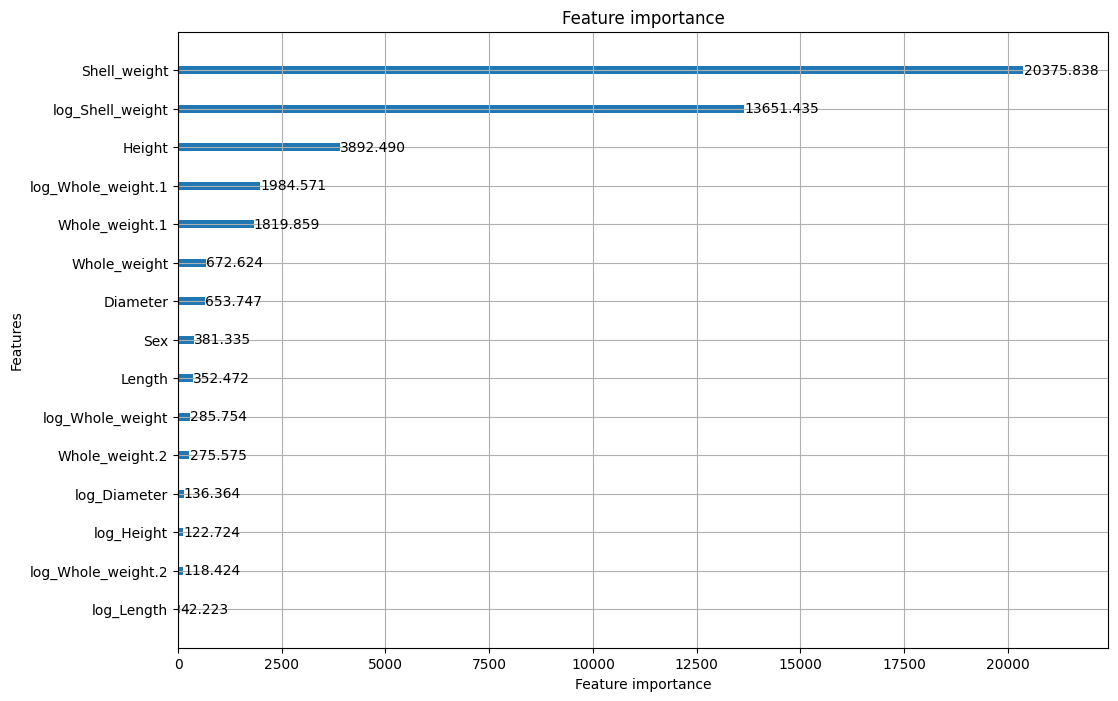

In [11]:
# Feature Importance
lgb.plot_importance(LGB, importance_type="gain", figsize=(12, 8))
plt.show()

### Training API

In [12]:
# パラメータの設定
params = {
    "objective": "regression",
    "verbosity": -1,
    "learning_rate": 0.05,
    "max_depth": 5,
    "min_child_weight": 1.0,
    "bagging_fraction": 0.8, # subsampleと同義
    "feature_fraction": 0.8, # colsample_bytreeと同義
    "random_state": PARAMS["seed"], 
}

# Datasetオブジェクトの作成
dtrain = lgb.Dataset(data=X_train_pp, label=y_train)
dtest = lgb.Dataset(data=X_test_pp)

# モデルの構築・学習
gbm = lgb.train(params, dtrain, valid_sets=[dtest], num_boost_round=200)

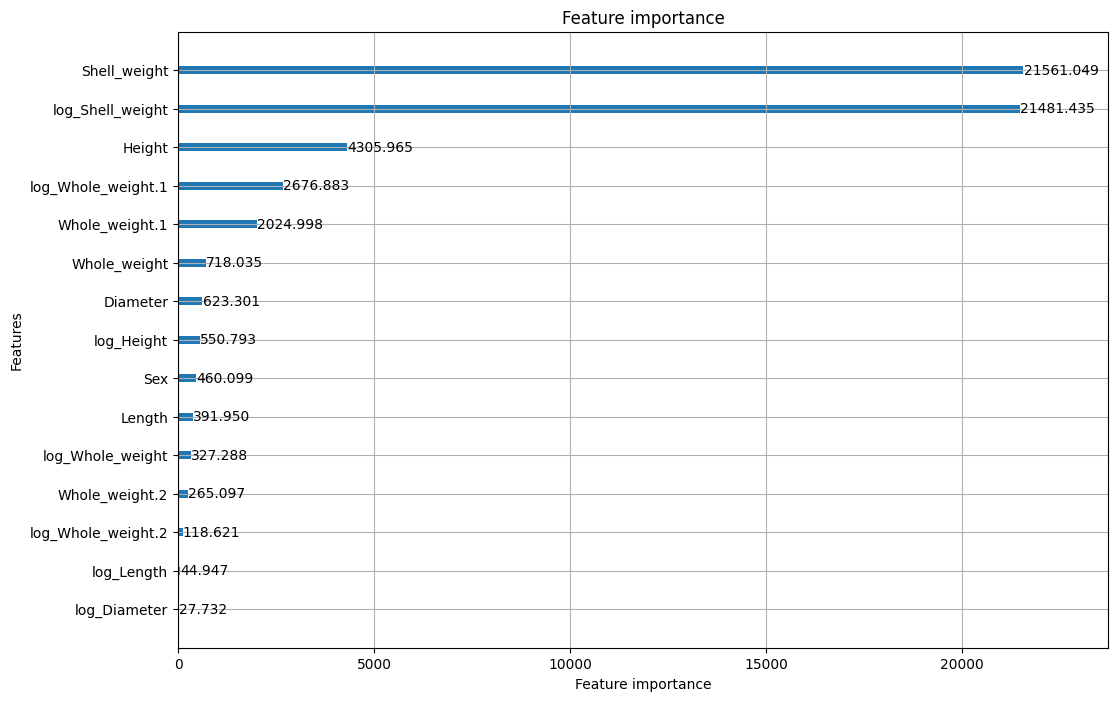

In [13]:
# Feature Importance
lgb.plot_importance(gbm, importance_type="gain", figsize=(12, 8))
plt.show()

## クロスバリデーション

In [14]:
val_scores, val_preds, test_preds = cross_val_train(X_train_pp, y_train, X_test, params)

Training until validation scores don't improve for 100 rounds
[500]	valid_0's l2: 0.0228378
[1000]	valid_0's l2: 0.0225811
Early stopping, best iteration is:
[1222]	valid_0's l2: 0.0225586
Fold: 0   Train RMSLE: 0.1369  Val RMSLE: 0.1502
--------------------------------------------------
Training until validation scores don't improve for 100 rounds
[500]	valid_0's l2: 0.0225477
[1000]	valid_0's l2: 0.022404
Early stopping, best iteration is:
[979]	valid_0's l2: 0.0224016
Fold: 1   Train RMSLE: 0.1383  Val RMSLE: 0.1497
--------------------------------------------------
Training until validation scores don't improve for 100 rounds
[500]	valid_0's l2: 0.0222188
[1000]	valid_0's l2: 0.022041
Early stopping, best iteration is:
[1056]	valid_0's l2: 0.0220282
Fold: 2   Train RMSLE: 0.1384  Val RMSLE: 0.1484
--------------------------------------------------
Training until validation scores don't improve for 100 rounds
[500]	valid_0's l2: 0.0221925
[1000]	valid_0's l2: 0.0221177
Early stoppin

In [15]:
print(f"Mean RMSLE: {np.mean(val_scores):.5f}")

Mean RMSLE: 0.14864


## submitの作成

In [16]:
# submitのidを抽出
sub = test_df.reset_index()[["id"]]

In [17]:
sub["Rings"] = np.exp(test_preds) - 1
sub.to_csv(os.path.join(DIRS["OUTPUT"], "submission_base.csv"), index=False)